## UMAP 차원축소

In [36]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


클러스터 수: 443
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 43735 samples in 0.036s...
[t-SNE] Computed neighbors for 43735 samples in 2.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43735
[t-SNE] Computed conditional probabilities for sample 2000 / 43735
[t-SNE] Computed conditional probabilities for sample 3000 / 43735
[t-SNE] Computed conditional probabilities for sample 4000 / 43735
[t-SNE] Computed conditional probabilities for sample 5000 / 43735
[t-SNE] Computed conditional probabilities for sample 6000 / 43735
[t-SNE] Computed conditional probabilities for sample 7000 / 43735
[t-SNE] Computed conditional probabilities for sample 8000 / 43735
[t-SNE] Computed conditional probabilities for sample 9000 / 43735
[t-SNE] Computed conditional probabilities for sample 10000 / 43735
[t-SNE] Computed conditional probabilities for sample 11000 / 43735
[t-SNE] Computed conditional probabilities for sample 12000 / 43735
[t-SNE] Computed conditional probabili

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

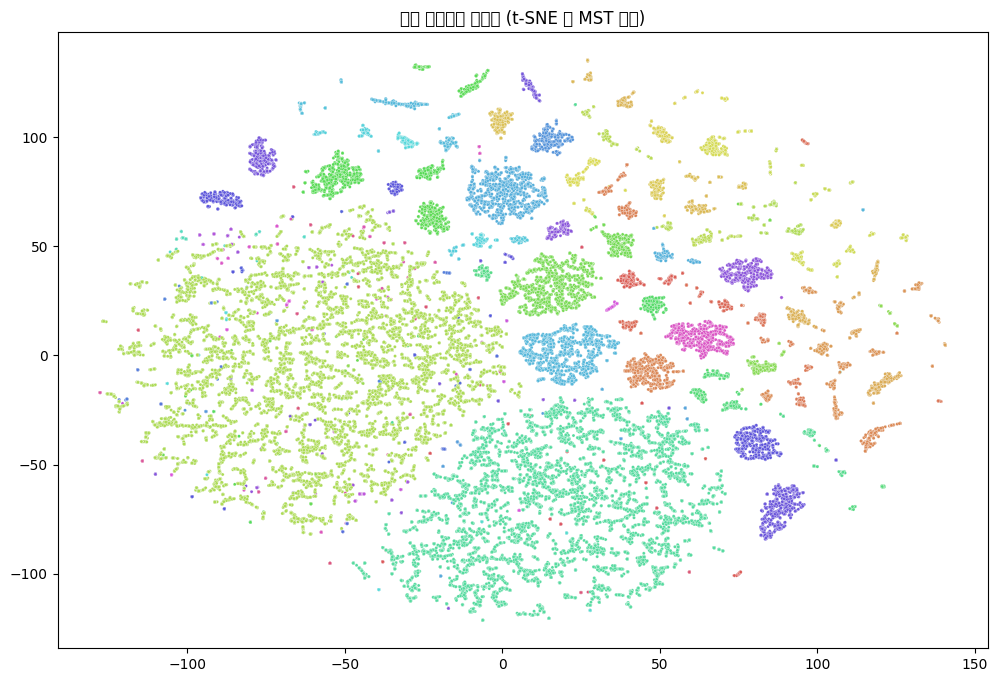

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx  # NetworkX 라이브러리 임포트

# Step 1: CSV 파일 읽기
df = pd.read_csv('/content/영화목록_processed.csv')

# '장르_개수'와 '사회_통합' 컬럼 위치 변경
columns = list(df.columns)
idx1 = columns.index('장르_개수')
idx2 = columns.index('사회_통합')
columns[idx1], columns[idx2] = columns[idx2], columns[idx1]
df = df[columns]

# Step 2: 장르 벡터 추출
genre_columns = df.columns[3:58]  # 'SF'부터 '로맨스통합'까지
genre_vectors = df[genre_columns].values

# Step 3: UMAP을 사용하여 차원 축소
# n_components는 원하는 차원으로 설정 (예: 5)
reducer = umap.UMAP(n_components=5, random_state=42)
genre_umap = reducer.fit_transform(genre_vectors)

# Step 4: KNN을 사용하여 유클리드 거리 기반의 유사도 계산
K = 1000  # 메모리 상황에 따라 조정 가능
nbrs = NearestNeighbors(n_neighbors=K, metric='euclidean', algorithm='auto').fit(genre_umap)
distances, indices = nbrs.kneighbors(genre_umap)

# Step 5: 간선 리스트 생성
num_movies = genre_umap.shape[0] #genre_umap의 행 개수를 가져옴
edges = []

for i in range(num_movies):
    for j in range(K):
        neighbor = indices[i][j]
        distance = distances[i][j]
        if i < neighbor:  # 중복 간선 방지
            edges.append((i, neighbor, distance))

# 간선 리스트를 DataFrame으로 변환
edges_df = pd.DataFrame(edges, columns=['node1', 'node2', 'weight'])

# Step 6: Kruskal 알고리즘을 사용하여 MST 생성
# 그래프 생성
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Kruskal 알고리즘을 사용하여 MST 계산
mst = nx.minimum_spanning_tree(G, algorithm='kruskal')

# Step 7: 엣지 제거를 통한 클러스터 형성
# 엣지 가중치 추출
edge_weights = np.array([data['weight'] for u, v, data in mst.edges(data=True)])

# 거리 역치값 설정 (예: 상위 1% 거리의 엣지 제거)
threshold = np.percentile(edge_weights, 99)

# 역치값 이상의 엣지 제거
edges_to_remove = [(u, v) for u, v, data in mst.edges(data=True) if data['weight'] > threshold]
mst.remove_edges_from(edges_to_remove)

# Step 8: 연결된 구성 요소(클러스터) 찾기
clusters = list(nx.connected_components(mst))
labels = np.zeros(num_movies, dtype=int)

for cluster_id, cluster in enumerate(clusters):
    for node in cluster:
        labels[node] = cluster_id

# 클러스터 수 출력
n_components = len(clusters)
print(f"클러스터 수: {n_components}")

# 클러스터 레이블을 데이터프레임에 추가
df['cluster'] = labels

# Step 9: t-SNE를 사용하여 시각화를 위한 2차원 축소
tsne = TSNE(n_components=2, random_state=42, verbose=1)
genre_tsne = tsne.fit_transform(genre_umap)

# 시각화를 위한 데이터프레임 생성
viz_df = pd.DataFrame()
viz_df['x'] = genre_tsne[:, 0]
viz_df['y'] = genre_tsne[:, 1]
viz_df['cluster'] = labels 

# 클러스터 수 확인
n_clusters = len(np.unique(labels))

# 색상 팔레트 생성
palette = sns.color_palette('hls', n_clusters)

# 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=viz_df, x='x', y='y', hue='cluster', palette=palette, legend=False, s=5)
plt.title('영화 클러스터 시각화 (t-SNE 및 MST 기반)')
plt.xlabel('')
plt.ylabel('')
plt.show()

# Step 10: 클러스터 요약 정보 CSV로 저장

# 장르 컬럼 이름 리스트 생성
genre_columns = df.columns[3:58]

# 클러스터 고유 값 추출
cluster_labels = sorted(df['cluster'].unique())

# 클러스터 정보를 저장할 리스트 초기화
cluster_info_list = []

# 상위 N개의 특징적인 태그 선택
top_N = 5  # 필요에 따라 변경 가능

# 각 클러스터에 대해 반복
for cluster_label in cluster_labels:
    # 해당 클러스터의 데이터 선택
    cluster_data = df[df['cluster'] == cluster_label]

    # 영화의 행 번호 리스트 추출
    movie_indices = cluster_data.index.tolist()

    # 장르 컬럼의 합계를 계산하여 특징적인 태그 파악
    tag_sums = cluster_data[genre_columns].sum()

    # 합계가 높은 상위 N개의 태그 선택
    top_tags = tag_sums.nlargest(top_N).index.tolist()

    # 클러스터 정보를 딕셔너리에 저장
    cluster_info = {
        'cluster': cluster_label,
        'movie_indices': ','.join(map(str, movie_indices)),
        'top_tags': ','.join(top_tags)
    }

    # 리스트에 추가
    cluster_info_list.append(cluster_info)

# 클러스터 정보 리스트를 DataFrame으로 변환
cluster_info_df = pd.DataFrame(cluster_info_list)

# 열 순서 조정
cluster_info_df = cluster_info_df[['cluster', 'movie_indices', 'top_tags']]

# CSV 파일로 저장
cluster_info_df.to_csv('cluster_summary.csv', index=False)